In [603]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emonsharkar/python-learning-and-exam-performance-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Playdata\.cache\kagglehub\datasets\emonsharkar\python-learning-and-exam-performance-dataset\versions\1


In [604]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestRegressor          # 결정 트리 기반 앙상블 모델
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score   # 회귀라 MAE, MSE, R2_SCORE
from sklearn.model_selection import train_test_split, GridSearchCV              # 학습/데스트 데이터 분할, 하이퍼파라미터 최적화
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지 설정


In [605]:

# csv 파일 읽어오기
df = pd.read_csv('data/python_learning_exam_performance.csv')
df

,student_id,age,country,prior_programming_experience,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam
0,1,54,Pakistan,Beginner,12,12.2,60,1,24,0,1,4,10,53.8,0
1,2,44,Nigeria,NaN,15,14.2,52,1,32,0,0,5,7,31.9,0
2,3,30,India,Intermediate,5,7.7,71,1,43,0,0,6,3,59.4,0
3,4,23,Nigeria,Beginner,4,5.6,64,2,40,1,0,3,10,58.8,0
4,5,36,UK,NaN,3,3.5,62,1,47,1,0,3,7,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,39,Brazil,NaN,1,9.3,60,2,41,1,1,4,4,27.9,0
2996,2997,34,Indonesia,Intermediate,6,5.8,63,2,35,0,0,3,3,41.9,0
2997,2998,52,Pakistan,Beginner,3,1.4,63,2,45,1,1,7,7,26.9,0
2998,2999,54,Pakistan,Intermediate,5,8.5,51,2,35,1,0,4,2,27.8,0


student_id(학생 ID) : 각 학생을 구분하기 위한 고유 식별 번호

age(나이) : 학습자의 나이 (범위: 16~55세)

country(국가) : 학생의 국적 또는 거주 국가 (예: India, Bangladesh, USA, UK 등)

prior_programming_experience(사전 프로그래밍 경험 수준) : Python 학습 시작 전 보유한 프로그래밍 경험 수준 (예: 없음, 초급, 중급 등 범주형)

weeks_in_course(수강 기간) : 학생이 Python 과정에 등록하여 학습한 기간 (단위: 주, 1~15주)

hours_spent_learning_per_week(주당 학습 시간) : 학생이 주당 평균적으로 Python 학습에 투자한 시간(단위: 시간)

practice_problems_solved(문제 풀이 수) : 해결한 코딩 연습 문제(코딩 챌린지)의 총 개수

projects_completed(완료한 프로젝트 수) : 학생이 완료한 Python 프로젝트의 개수

tutorial_videos_watched(튜토리얼 영상 시청 수) : Python 관련 강의 또는 튜토리얼 영상 시청 횟수

uses_kaggle(Kaggle 사용 여부) : Kaggle 플랫폼을 활용하여 학습했는지 여부 (0: 사용 안 함, 1: 사용)

participates_in_discussion_forums(토론 포럼 참여 여부) : 온라인 토론 게시판이나 커뮤니티에 참여했는지 여부 (0: 미참여, 1: 참여)

debugging_sessions_per_week(주당 디버깅 횟수) : 주당 평균 디버깅을 수행한 횟수

self_reported_confidence_python(Python 자신감 점수) : 학습자가 스스로 평가한 Python 숙련도 및 자신감 수준 (1~10점 척도)

final_exam_score(최종 시험 점수) : Python 과정 최종 시험 점수 (범위: 0~100점)

passed_exam(시험 합격 여부) : 최종 시험 합격 여부 (0: 불합격, 1: 합격)

### 예상 Feature
### final_exam_score                     타깃
### practice_problems_solved             Feature
### hours_spent_learning_per_week        Feature
### projects_completed                   Feature
### self_reported_confidence_python      Feature
### prior_programming_experience         Feature
### (+ is_experience_unknown)            Feature

In [606]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   student_id                         3000 non-null   int64  
 1   age                                3000 non-null   int64  
 2   country                            3000 non-null   object 
 3   prior_programming_experience       1938 non-null   object 
 4   weeks_in_course                    3000 non-null   int64  
 5   hours_spent_learning_per_week      3000 non-null   float64
 6   practice_problems_solved           3000 non-null   int64  
 7   projects_completed                 3000 non-null   int64  
 8   tutorial_videos_watched            3000 non-null   int64  
 9   uses_kaggle                        3000 non-null   int64  
 10  participates_in_discussion_forums  3000 non-null   int64  
 11  debugging_sessions_per_week        3000 non-null   int64

In [607]:
df.isnull().sum()

# 경험 NAN 넌 뭐냐 

student_id                              0
age                                     0
country                                 0
prior_programming_experience         1062
weeks_in_course                         0
hours_spent_learning_per_week           0
practice_problems_solved                0
projects_completed                      0
tutorial_videos_watched                 0
uses_kaggle                             0
participates_in_discussion_forums       0
debugging_sessions_per_week             0
self_reported_confidence_python         0
final_exam_score                        0
passed_exam                             0
dtype: int64

In [608]:
print(df[df['prior_programming_experience'].isnull()].count().sum())
print(df[(df['prior_programming_experience'].isnull()) & (df['projects_completed']<2)].count().sum())

print(df.count().sum())
print(df[df['projects_completed']<2].count().sum())

14868
6202
43938
17572


In [609]:
# 결측치 fillna 및 경험여부 파생 컬럼을 추가
df['prior_programming_experience'] = df['prior_programming_experience'].fillna('Unknown')
df['is_experience_unknown'] = (df['prior_programming_experience'] == 'Unknown'
).astype(int)

###  원본 변수만으로도 의미 있는 결과를 도출해낼 수 있다고 판단하여 파생변수는 추가하지 않고 모델링을 진행함.

In [610]:
df

,student_id,age,country,prior_programming_experience,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam,is_experience_unknown
0,1,54,Pakistan,Beginner,12,12.2,60,1,24,0,1,4,10,53.8,0,0
1,2,44,Nigeria,Unknown,15,14.2,52,1,32,0,0,5,7,31.9,0,1
2,3,30,India,Intermediate,5,7.7,71,1,43,0,0,6,3,59.4,0,0
3,4,23,Nigeria,Beginner,4,5.6,64,2,40,1,0,3,10,58.8,0,0
4,5,36,UK,Unknown,3,3.5,62,1,47,1,0,3,7,24.8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,39,Brazil,Unknown,1,9.3,60,2,41,1,1,4,4,27.9,0,1
2996,2997,34,Indonesia,Intermediate,6,5.8,63,2,35,0,0,3,3,41.9,0,0
2997,2998,52,Pakistan,Beginner,3,1.4,63,2,45,1,1,7,7,26.9,0,0
2998,2999,54,Pakistan,Intermediate,5,8.5,51,2,35,1,0,4,2,27.8,0,0


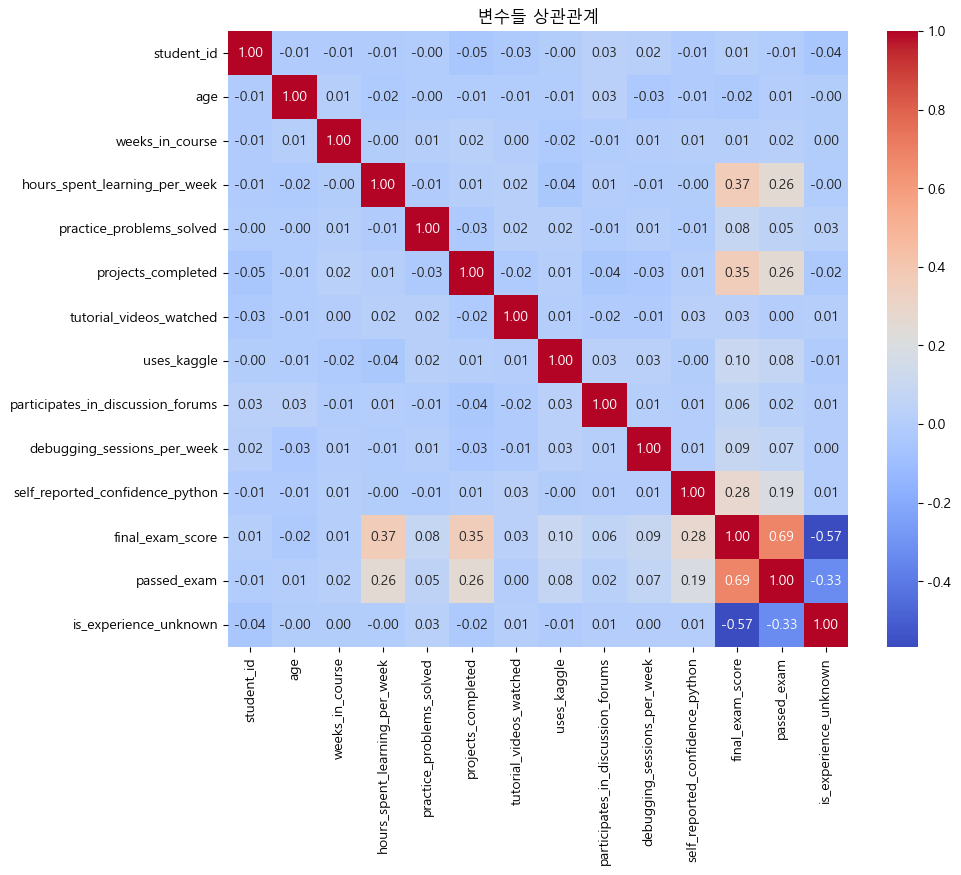

In [611]:
plt.figure(figsize=(10, 8))
corr_df = df.corr(numeric_only=True) # 수치형 변수들만 상관관계 계산

sns.heatmap(
    corr_df,                         # 상관관계 데이터
    annot=True,                      # 내부 값 표시
    fmt = '.2f',                     # 값 형태(소수점 2자리)
    cmap = 'coolwarm'
)
plt.title('변수들 상관관계')
plt.show()

<Axes: xlabel='practice_problems_solved', ylabel='final_exam_score'>

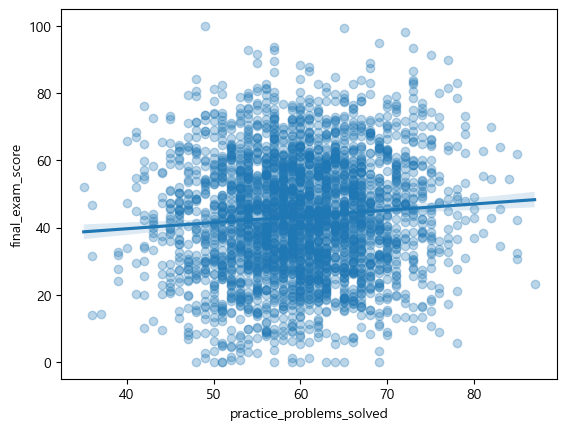

In [612]:
# 단변량 그래프로 거의 무관함을 확인
sns.regplot(
    x='practice_problems_solved',
    y='final_exam_score',
    data=df,
    scatter_kws={'alpha':0.3}
)

### 예상 Feature

### final_exam_score                     타깃
### practice_problems_solved             Feature 탈락
### hours_spent_learning_per_week        Feature
### projects_completed                   Feature
### self_reported_confidence_python      Feature
### prior_programming_experience         Feature
### (+ is_experience_unknown)            Feature -0.57 알고보니 무관하지 않더라 > 제거 *

In [613]:
df.describe()

,student_id,age,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam,is_experience_unknown
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,35.327000,8.121000,7.035267,59.983667,2.001333,39.896667,0.400667,0.498333,4.973333,5.566000,43.318267,0.177333,0.354000
std,866.169729,11.302182,4.275019,2.936134,7.713056,1.395701,6.263258,0.490115,0.500081,2.236729,2.885207,17.376666,0.382014,0.478289
min,1.000000,16.000000,1.000000,0.000000,35.000000,0.000000,19.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,750.750000,26.000000,5.000000,5.000000,55.000000,1.000000,35.000000,0.000000,0.000000,3.000000,3.000000,30.900000,0.000000,0.000000
50%,1500.500000,36.000000,8.000000,7.000000,60.000000,2.000000,40.000000,0.000000,0.000000,5.000000,6.000000,43.100000,0.000000,0.000000
75%,2250.250000,45.000000,12.000000,9.000000,65.000000,3.000000,44.000000,1.000000,1.000000,6.000000,8.000000,55.600000,0.000000,1.000000
max,3000.000000,54.000000,15.000000,17.100000,87.000000,9.000000,63.000000,1.000000,1.000000,17.000000,10.000000,100.000000,1.000000,1.000000


In [614]:
# 프로젝트 진행 여부로 파생변수를 만들어 보려고했으나 비진행자가 너무 적음 
df[df['projects_completed'] < 1]

,student_id,age,country,prior_programming_experience,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam,is_experience_unknown
5,6,54,Brazil,Intermediate,10,8.4,64,0,35,0,1,3,3,43.8,0,0
13,14,18,Germany,Unknown,12,8.4,69,0,36,0,1,5,8,39.6,0,1
34,35,54,Indonesia,Unknown,13,10.2,45,0,36,0,1,7,4,39.6,0,1
39,40,24,Nigeria,Beginner,13,12.0,54,0,45,0,0,5,1,39.5,0,0
59,60,51,Brazil,Beginner,1,5.2,69,0,40,1,0,3,1,23.4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2966,2967,47,Germany,Beginner,13,4.0,73,0,39,0,0,6,6,25.6,0,0
2969,2970,20,UK,Beginner,11,8.2,55,0,43,0,0,4,3,28.0,0,0
2987,2988,28,Germany,Beginner,1,7.3,59,0,49,0,0,3,10,46.9,0,0
2990,2991,51,India,Advanced,6,11.6,51,0,33,1,0,11,7,70.8,1,0


In [615]:
keep_cols = [
    'final_exam_score',
    'hours_spent_learning_per_week',
    'projects_completed',
    'self_reported_confidence_python',
    'prior_programming_experience',
]
df = df[keep_cols]

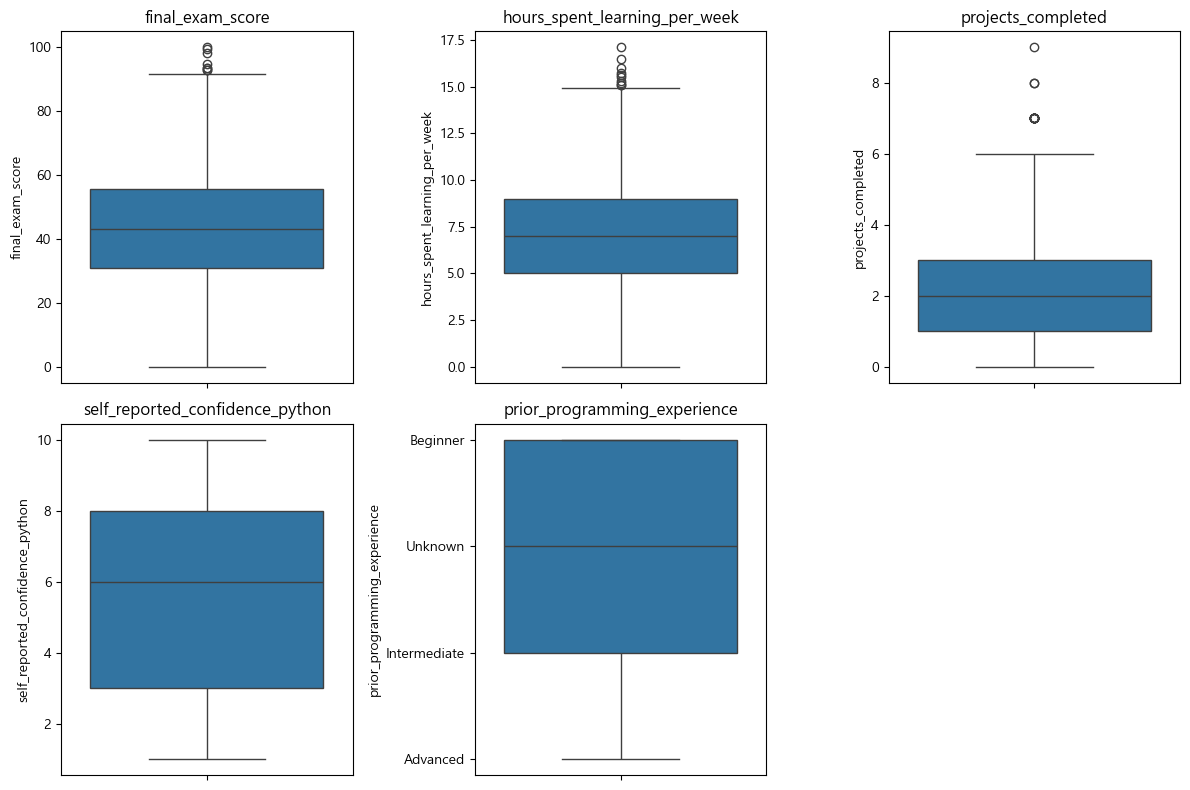

<Figure size 640x480 with 0 Axes>

In [616]:
plt.figure(figsize=(12, 8))

n_cols = 3
n_rows = math.ceil(len(df.columns) / n_cols)

for i, col in enumerate(df.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

### 수치상으로 이상하지는 않은 수치들임

In [617]:
df

,final_exam_score,hours_spent_learning_per_week,projects_completed,self_reported_confidence_python,prior_programming_experience
0,53.8,12.2,1,10,Beginner
1,31.9,14.2,1,7,Unknown
2,59.4,7.7,1,3,Intermediate
3,58.8,5.6,2,10,Beginner
4,24.8,3.5,1,7,Unknown
...,...,...,...,...,...
2995,27.9,9.3,2,4,Unknown
2996,41.9,5.8,2,3,Intermediate
2997,26.9,1.4,2,7,Beginner
2998,27.8,8.5,2,2,Intermediate


In [618]:
mapping = {
    'Unknown': 0,
    'Beginner': 1,
    'Intermediate': 2,
    'Advanced': 3
}

df['prior_programming_experience'] = (
    df['prior_programming_experience'].map(mapping)
)


C:\Users\Playdata\AppData\Local\Temp\ipykernel_39232\293461678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prior_programming_experience'] = (


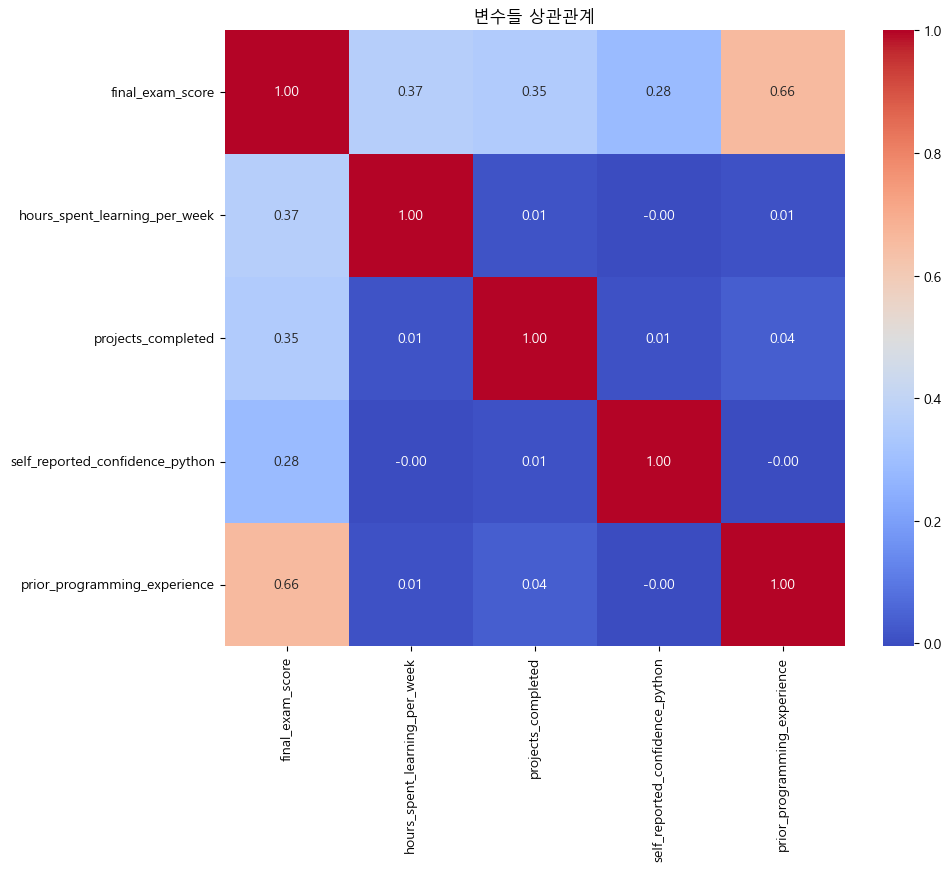

In [619]:
plt.figure(figsize=(10, 8))
corr_df = df.corr(numeric_only=True) # 수치형 변수들만 상관관계 계산

sns.heatmap(
    corr_df,                         # 상관관계 데이터
    annot=True,                      # 내부 값 표시
    fmt = '.2f',                     # 값 형태(소수점 2자리)
    cmap = 'coolwarm'
)
plt.title('변수들 상관관계')
plt.show()

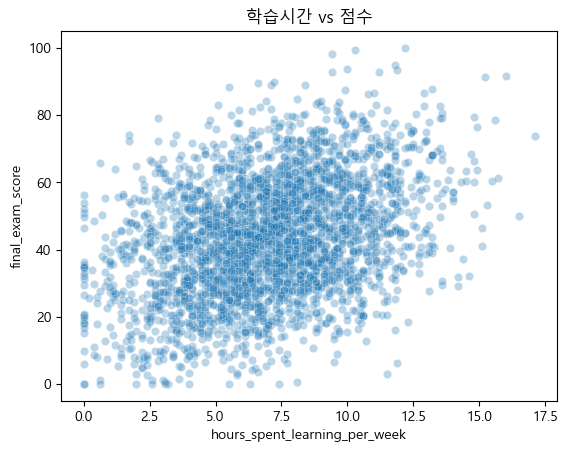

In [620]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df,
    x='hours_spent_learning_per_week',
    y='final_exam_score',
    alpha=0.3
)
plt.title('학습시간 vs 점수')
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_39232\2569534935.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


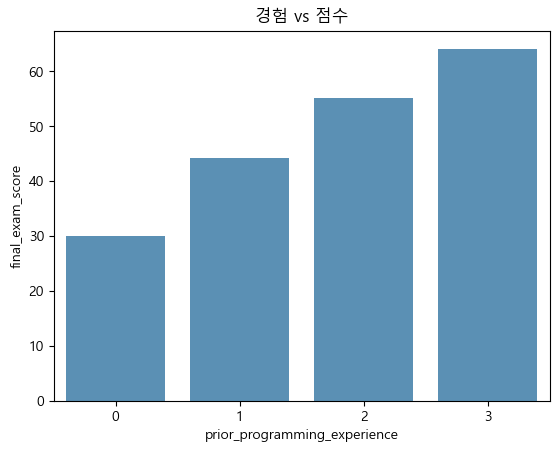

In [621]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=df,
    x='prior_programming_experience',
    y='final_exam_score',
    estimator='mean',
    ci=None,
    alpha=0.8
)
plt.title('경험 vs 점수')
plt.show()

## 1. RandomForest
### > 이 데이터는 학습 시간, 프로젝트 경험 등 변수 간 수치폭이 다양함. 
### > 학습 행동과 시험 성과의 관계가 선형적이지 않을 가능성이 있음.
### >  스케일링이 필요 없고 비선형 패턴을 잘 학습하는 랜덤포레스트 모델을 먼저 선택

In [622]:
# 누수방지를 위한 train, test 분리
X = df.drop('final_exam_score', axis=1)
y = df['final_exam_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
print(len(X_train),len(X_test),len(y_train),len(y_test))

2400 600 2400 600


In [623]:
rf_model = RandomForestRegressor(max_depth=5, random_state=42)

rf_model.fit(X_train,y_train)
rf_predict = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, rf_predict)
rmse = np.sqrt(mean_squared_error(y_test, rf_predict))
r2 = r2_score(y_test, rf_predict)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


MAE : 7.488565497455635
RMSE: 9.611091258552976
R2  : 0.6792630682112714


In [624]:
rf_model = RandomForestRegressor(max_depth=5, random_state=42)

# 3) tuning (train only, CV)

param_dist_small = {
    "n_estimators": [300, 600],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "max_features": ["sqrt"],
}

grid_search = GridSearchCV(
    rf_model,                                               # 최적 파라미터를 뽑아낼 모델
    param_dist_small,                                       # 최적 파라미터를 테스트할 값
    cv = 5,                                                 # 5-fold 교차 검증  
    scoring = 'neg_mean_squared_error',                     # 성능 평가지포 : 평균제곱오차 MSE
    n_jobs = -1,                                            # 모든 CPU 사용(병렬)
    verbose = 2                                             # 진행사항 출력
)

grid_search.fit(X_train,y_train)
rf_predict = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, rf_predict)
rmse = np.sqrt(mean_squared_error(y_test, rf_predict))
r2 = r2_score(y_test, rf_predict)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE : 7.005367839324957
RMSE: 8.966043919299132
R2  : 0.7208707862686891


## 2. Cat Boost
### > 범주형을 순서·통계 누수 없이 내부적으로 처리
### > 중간 규모 + 교육/행동 데이터

In [625]:
# cat_features = [
#     'prior_programming_experience'
# ]
# 범주형이라는 걸 알고 다르게 처리하는 개념인데 항목이 네개밖에 안되어서 효용이 없어서 사용하지 않았다.

train_pool = Pool(X_train,y_train)
test_pool = Pool(X_test,y_test)

cb_model = CatBoostRegressor(
    iterations=500,    
    depth=6,
    learning_rate=0.05,
    random_seed=777,
    verbose=False
)

cb_model.fit(X_train,y_train)
cb_predict = cb_model.predict(X_test)

mae = mean_absolute_error(y_test, cb_predict)
rmse = np.sqrt(mean_squared_error(y_test, cb_predict))
r2 = r2_score(y_test, cb_predict)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

MAE : 6.8165257282551766
RMSE: 8.71738091024676
R2  : 0.736138750498115


In [626]:

# 캣부스트의 강점을 사용해보기 위해 매핑을 다시 돌려봤다.
reverse_mapping = {
 0: 'Unknown',
 1: 'Beginner',
 2: 'Intermediate',
 3: 'Advanced'
}

df['prior_programming_experience'] = (
    df['prior_programming_experience']
    .map(reverse_mapping)
)

cat_features = [
    'prior_programming_experience'
]


train_pool = Pool(X_train,y_train, cat_features=cat_features)
test_pool = Pool(X_test,y_test, cat_features=cat_features)

cb_model = CatBoostRegressor(
    iterations=500,    
    depth=6,
    learning_rate=0.05,
    random_seed=777,
    verbose=False
)

cb_model.fit(train_pool)
cb_predict = cb_model.predict(test_pool)
mae = mean_absolute_error(y_test, cb_predict)
rmse = np.sqrt(mean_squared_error(y_test, cb_predict))
r2 = r2_score(y_test, cb_predict)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


C:\Users\Playdata\AppData\Local\Temp\ipykernel_39232\3751099800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prior_programming_experience'] = (


MAE : 6.764727246971189
RMSE: 8.686778616203405
R2  : 0.7379880642859109


# 아주 약간 효과가 있었다....

In [627]:
# 복구
mapping = {
    'Unknown': 0,
    'Beginner': 1,
    'Intermediate': 2,
    'Advanced': 3
}

df['prior_programming_experience'] = (
    df['prior_programming_experience'].map(mapping)
)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_39232\2545367380.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prior_programming_experience'] = (


# 3. XGBoost

In [628]:
xgb_param_grid = {
    'n_estimators': [100,200]           # 트리 갯수
    ,'max_depth' : [None, 10, 20]       # 트리 최대 깊이
    ,'learning_machine': [0.1, 0.01]    # 학습률 (클수록 빠른 학습, 불안정 증가)
    ,'min_child_weight':[1,2]           # 리프노드 최소 가중치를 
}

xgb_model = XGBRegressor(random_state = 777)

xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=5,                                   # 5 fold 교차검증
    scoring = 'neg_mean_squared_error',     # 평균제곱오차 MSE
    n_jobs = -1,                            # 모든 CPU 사용(병렬)
    verbose = 2                             # 진행사항 출력
)

xgb_grid_search.fit(X_train,y_train)
xgb_model = xgb_grid_search.best_estimator_
xgb_model.fit(X_train,y_train)
xgb_predict = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, xgb_predict)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predict))
r2 = r2_score(y_test, xgb_predict)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:53:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "learning_machine" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Playdata\machine_learning\machine_learning_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:53:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "learning_machine" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MAE : 7.561963254928589
RMSE: 9.646254412009984
R2  : 0.6769118777532603


# 4. LightGBM

In [629]:
lgbm_param_grid = {
    'n_estimators': [100,200]           # 트리 갯수
    ,'max_depth' : [None, 10, 20]       # 트리 최대 깊이
    ,'learning_rate': [0.1, 0.01]    # 학습률 (클수록 빠른 학습, 불안정 증가)
    ,'min_child_samples':[1,2]           # 리프노드 최소 가중치를 
}

lgbm_model = LGBMRegressor(random_state = 777)

lgbm_grid_search = GridSearchCV(
    lgbm_model,
    lgbm_param_grid,
    cv=5,                                   # 5 fold 교차검증
    scoring = 'neg_mean_squared_error',     # 평균제곱오차 MSE
    n_jobs = -1,                            # 모든 CPU 사용(병렬)
    verbose = 2                             # 진행사항 출력
)

lgbm_grid_search.fit(X_train,y_train)
lgbm_model = lgbm_grid_search.best_estimator_
lgbm_model.fit(X_train,y_train)
lgbm_predict = lgbm_model.predict(X_test)

mae = mean_absolute_error(y_test, lgbm_predict)
rmse = np.sqrt(mean_squared_error(y_test, lgbm_predict))
r2 = r2_score(y_test, lgbm_predict)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 4
[LightGBM] [Info] Start training from score 43.364792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 4
[LightGBM] [Info] Start training from score 43.364792
MAE : 7.053135860421174
RMSE: 9.00377434795881
R2  : 0.7185166099170583


### 모든 모델은 train/test 분할을 사용했고, 하이퍼파라미터 튜닝은 학습 데이터 내 (cv=5) 교차검증만 사용했다.

# CAT Boost가 최종 모델이다
## 여러 트리 기반 모델을 비교한 결과, CatBoost는 범주형 처리 측면에서 안정적 및 최고점

## * MAE : 6.764727246971189
## * RMSE: 8.686778616203405
## * R2  : 0.7379880642859109

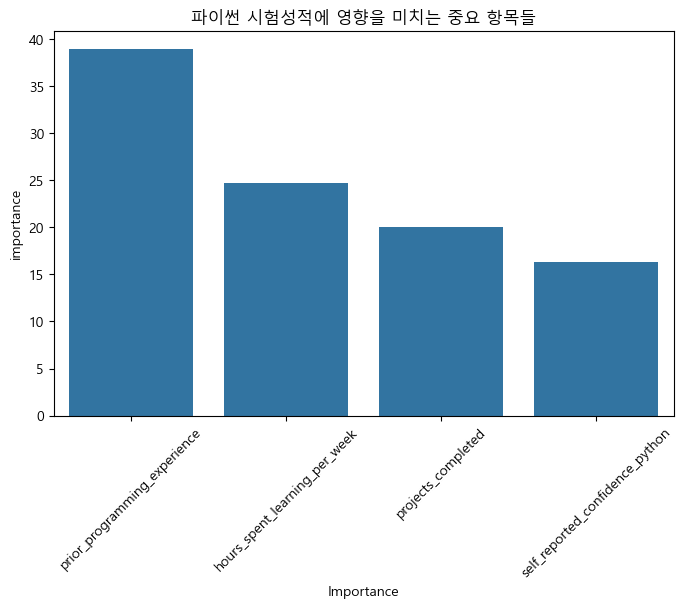

In [630]:
# cat부스트에서 get_feature_importance 함수로 점수에 영향을 끼치는 중요도를 확인한다.

importances = cb_model.get_feature_importance()
feature_names = X_train.columns
final_df = pd.DataFrame({
    'features' : feature_names,
    'importance' : importances
}).sort_values(by='importance',ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x=final_df['features'],y=final_df['importance'])
plt.title('파이썬 시험성적에 영향을 미치는 중요 항목들')
plt.xlabel('Importance')
plt.xticks(rotation=45)
plt.show()

1. 사전 프로그래밍 경험 수준 : Python 학습 시작 전 보유한 프로그래밍 경험 수준 (예: 없음, 초급, 중급 등 범주형)
2. 주당 학습 시간 : 학생이 주당 평균적으로 Python 학습에 투자한 시간(단위: 시간)
3. 완료한 프로젝트 수 : 학생이 완료한 Python 프로젝트의 개수
4. Python 자신감 점수 : 학습자가 스스로 평가한 Python 숙련도 및 자신감 수준 (1~10점 척도)

In [ ]:
# 값을 넣어서 예측 및 비교해보기

scenario = pd.DataFrame({
    'hours_spent_learning_per_week': [8, 12, 16],
    'prior_programming_experience': [1, 2, 3],
    'projects_completed': [1, 2, 1],
    'self_reported_confidence_python': [5, 7, 8]
})

scenario = scenario[X_train.columns]
scenario['predicted_score'] = cb_model.predict(scenario)
scenario

,hours_spent_learning_per_week,projects_completed,self_reported_confidence_python,prior_programming_experience,predicted_score
0,8,1,5,1,42.900615
1,12,2,7,2,70.134583
2,16,1,1,3,73.145625


In [640]:
# 재미로 보는 양창일 점수 예측

scenario = pd.DataFrame({
    'hours_spent_learning_per_week': [40],              # 수업시간만 일주일에                                                                  40시간
    'prior_programming_experience': [2],                # Python 학습 시작 전 보유한 프로그래밍 경험 수준 (예: 없음, 초급, 중급,고급 등 범주형)     중급
    'projects_completed': [1],                          # 학생이 완료한 Python 프로젝트의 개수                                                  1개
    'self_reported_confidence_python': [8]              # 학습자가 스스로 평가한 Python 숙련도 및 자신감 수준                                     8점
})

scenario = scenario[X_train.columns]
scenario['predicted_score'] = cb_model.predict(scenario)
scenario

,hours_spent_learning_per_week,projects_completed,self_reported_confidence_python,prior_programming_experience,predicted_score
0,40,1,8,2,75.933959


### 학습시 
1. 학습 시간을 충분히 확보하는 것이 가장 중요하다.
2. 프로젝트 완료 수가 영향을 끼치는 것으로 보아 실습을 많이 할 수록 실력이 빠르게 상승한다는 것을 알 수 있었다. 
3. 타 프로그래밍 경험은 파이썬 학습에 일정 수준의 영향을 미친다.
4. 자신감을 갖는것도 좋다.

### 교육시
1. 실습이 많으면 좋다.
2. 타 프로그래밍 경험자와 무경험자 간 초기 격차를 고려한 교육 설계가 필요하다.
3. 학생들의 학습 자신감을 높일 수 있는 피드백과 학습 환경 조성이 중요하다.